In [8]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import scipy.optimize as opt

In [9]:
def f(x, a):
    return (a[1]*x+a[0]) / (x + a[2])

def generate_uniform(N):
    target_std = 0.05
    a = target_std * np.sqrt(3)
    return np.random.uniform(-a, a, N)

def generate_normal(N):
    return np.random.normal(0, 0.05, N)

def generate_laplace(N):
    target_std = 0.05
    lambda_param = np.sqrt(2) / target_std
    scale = 1 / lambda_param
    return np.random.laplace(loc=0, scale=scale, size=N)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 580.36it/s]


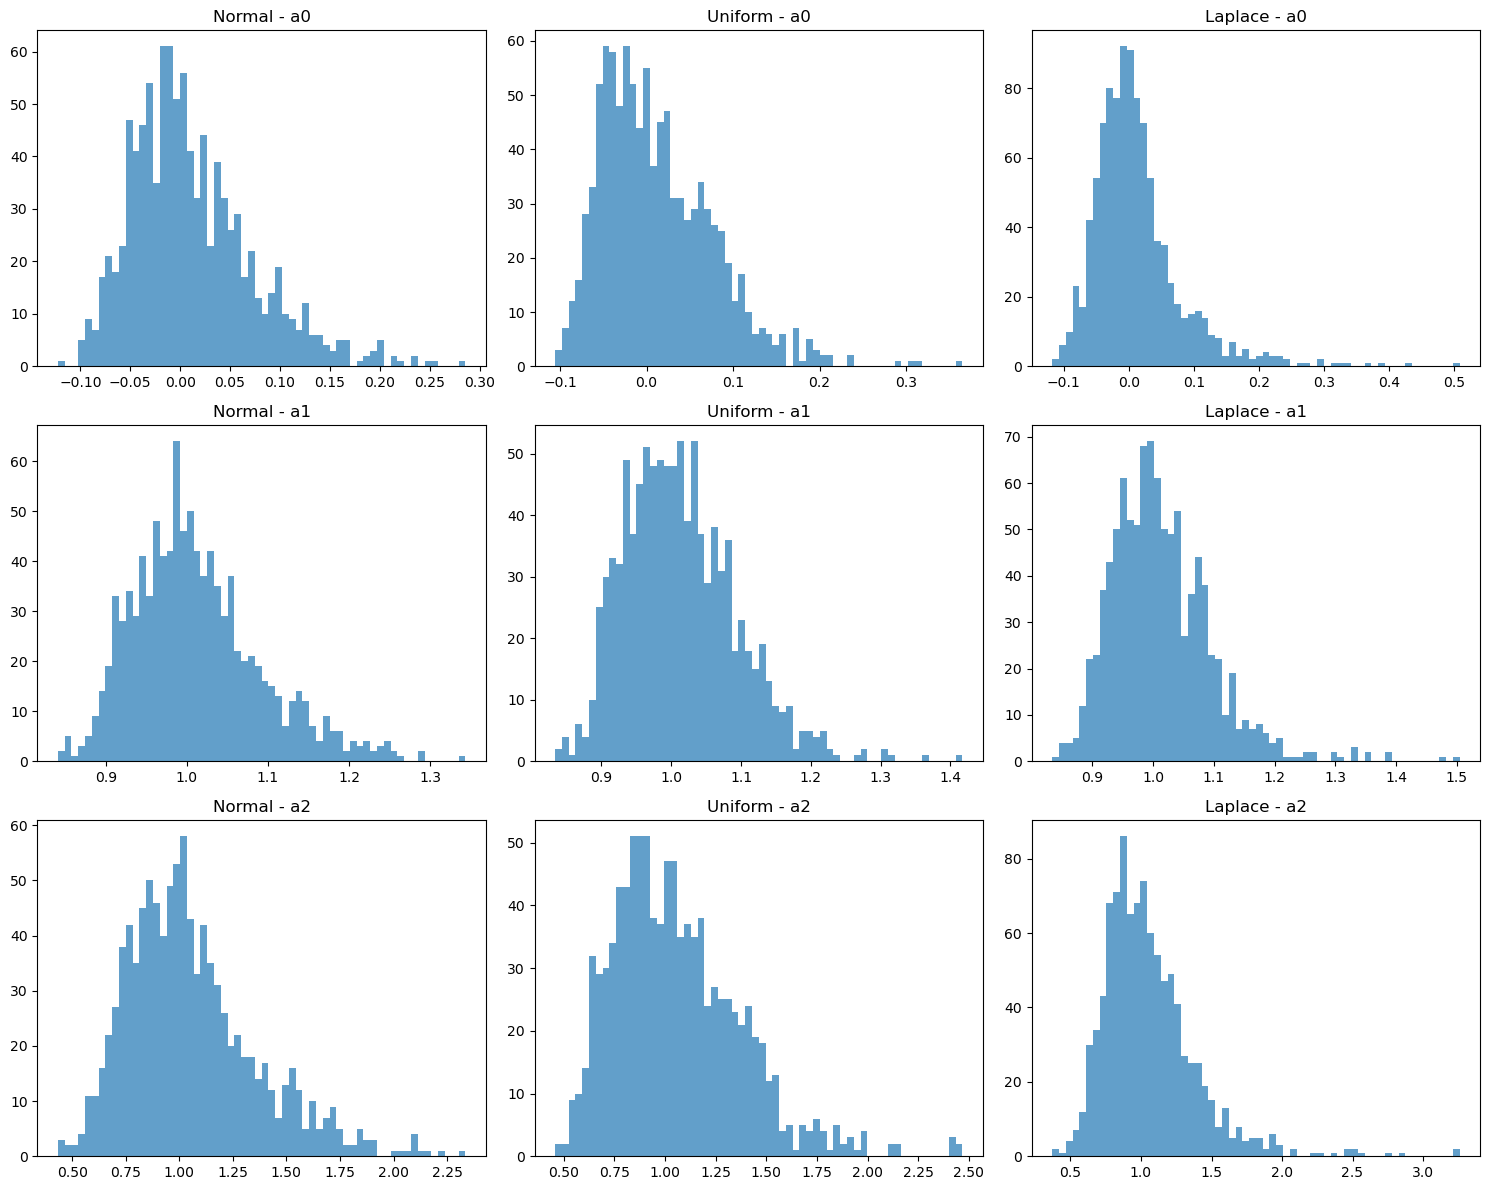

Средние дисперсии параметров для метода ols:
	normal: [0.004, 0.006, 0.093]
	uniform: [0.004, 0.006, 0.099]
	laplace: [0.005, 0.007, 0.112]


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.10it/s]


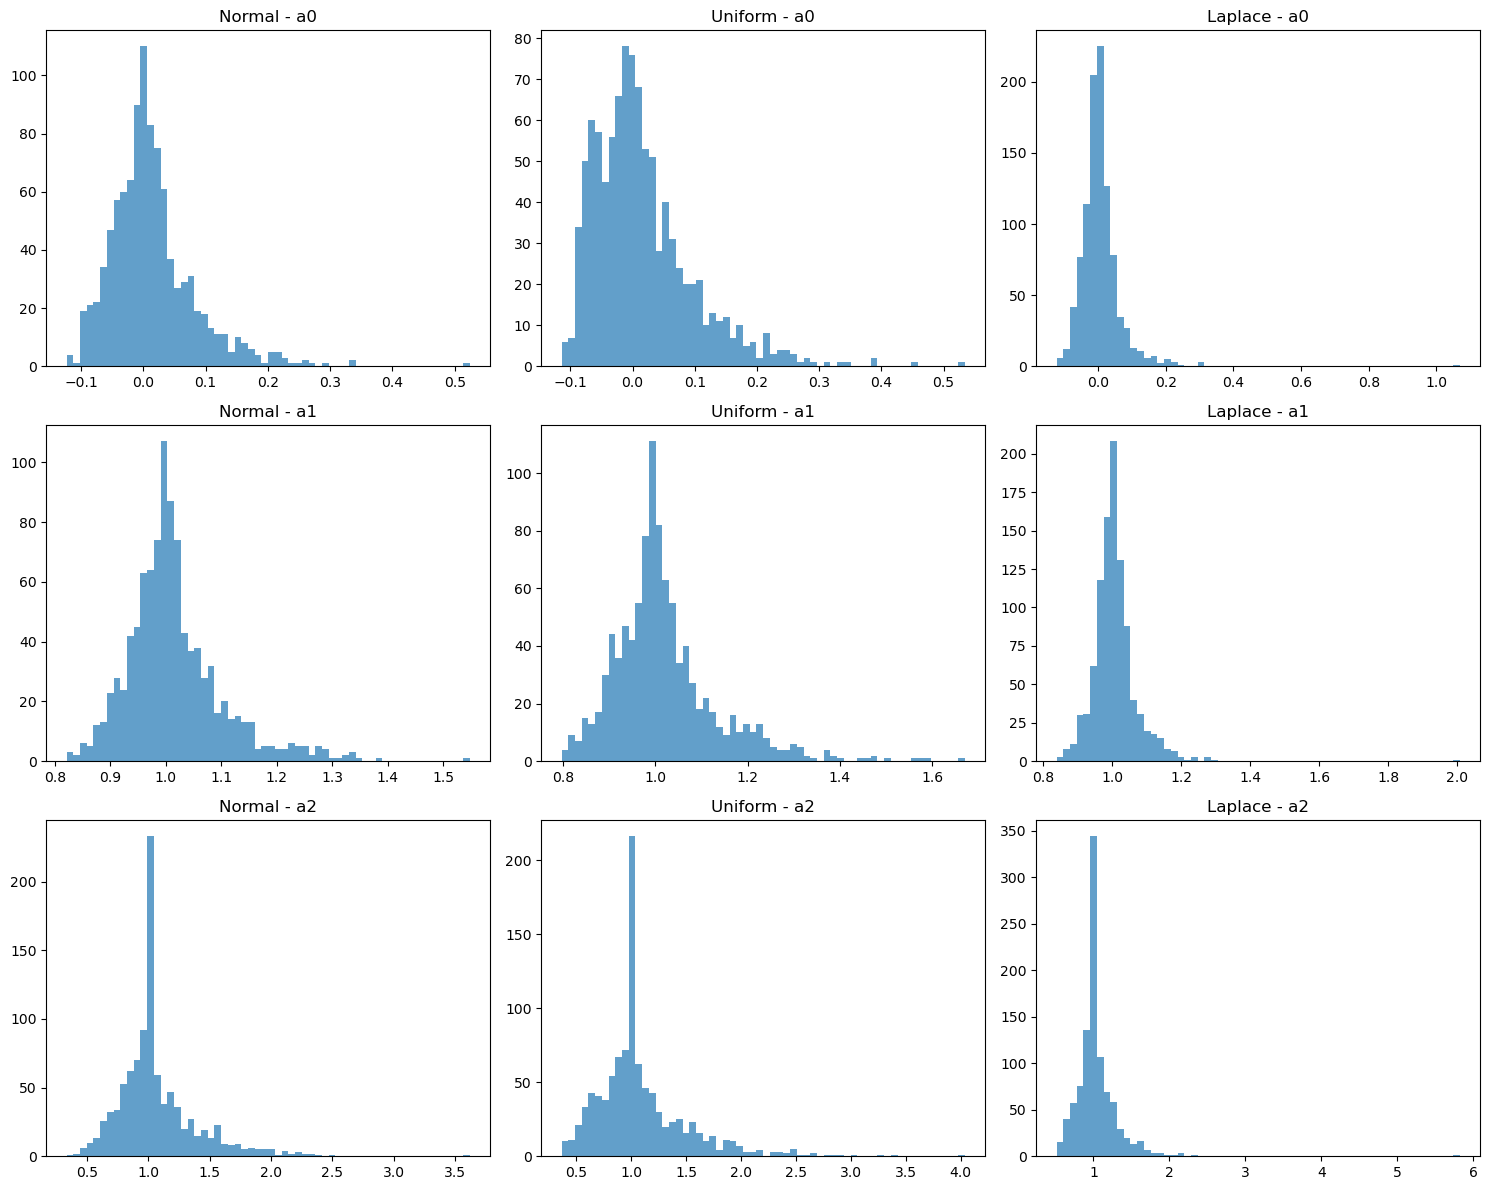

Средние дисперсии параметров для метода lar:
	normal: [0.005, 0.007, 0.106]
	uniform: [0.007, 0.013, 0.178]
	laplace: [0.004, 0.005, 0.077]


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.08it/s]


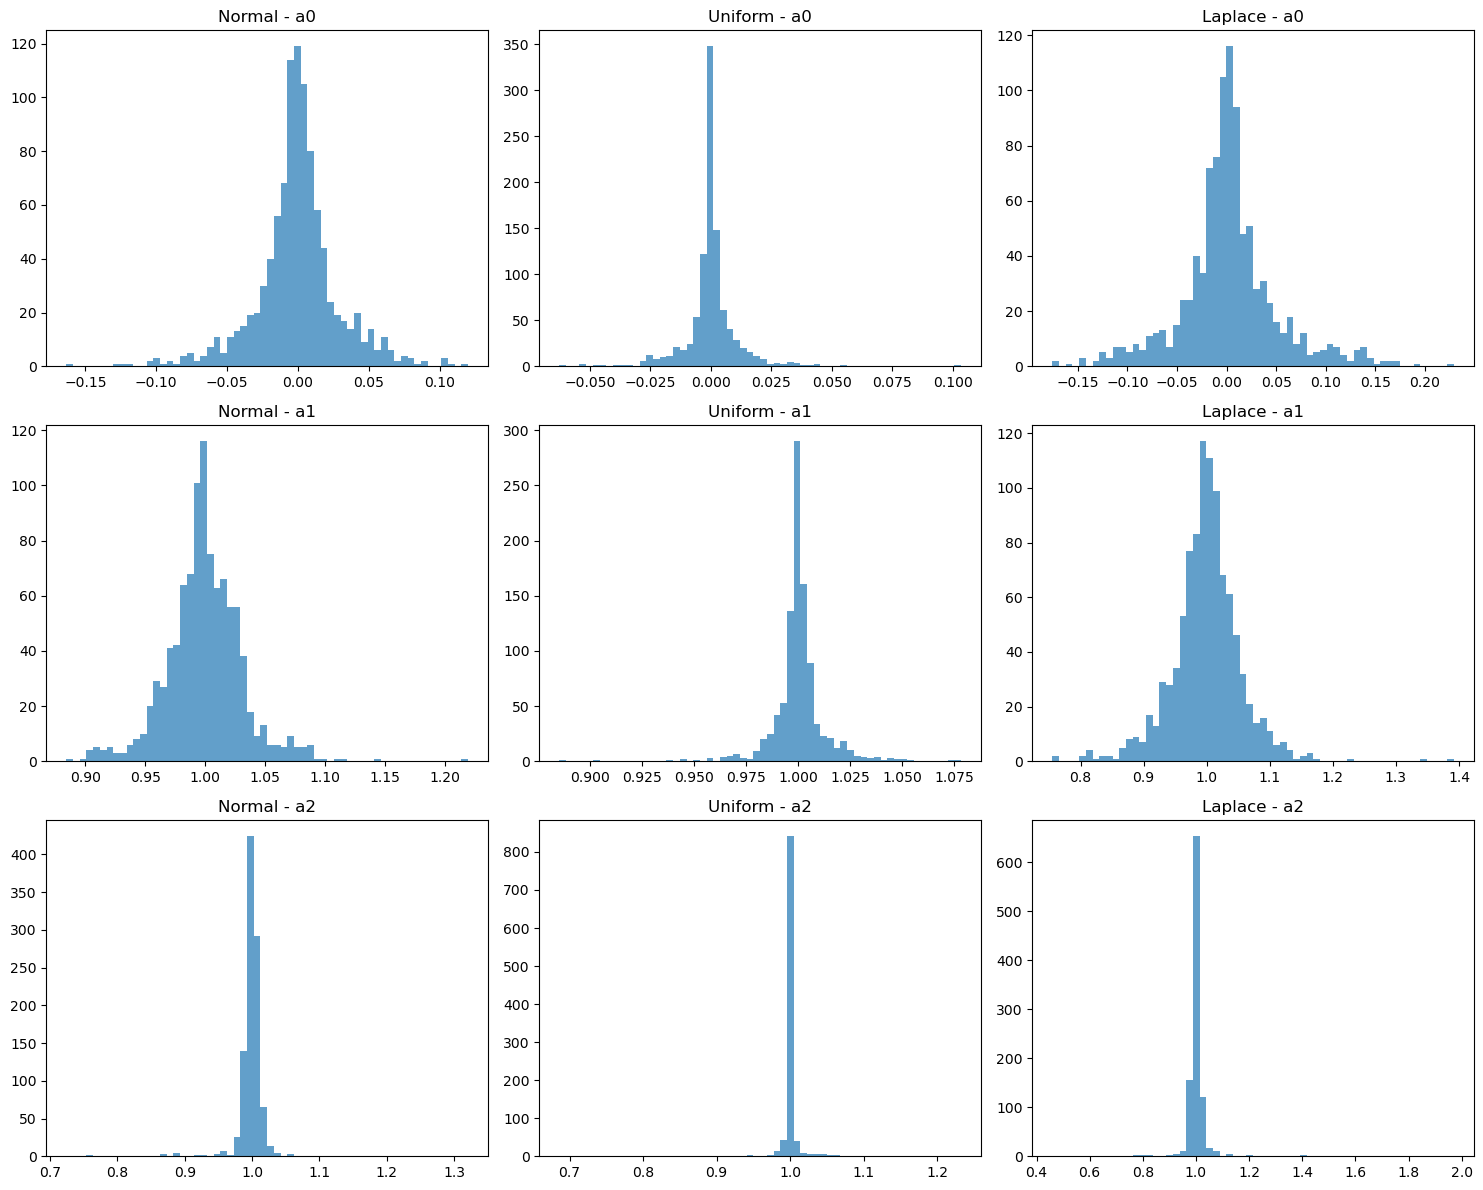

Средние дисперсии параметров для метода minimax:
	normal: [0.001, 0.001, 0.001]
	uniform: [0.0, 0.0, 0.001]
	laplace: [0.002, 0.003, 0.003]


In [10]:
def residuals(a, x, y):
    return y - f(x, a)

def residuals_lar(a, x, y):
    return np.sum(np.abs(y - f(x, a)))

def residuals_minimax(a, x, y):
    return np.max(np.abs(y - f(x, a)))

def estimate_params(method, x, y, a_init):
    if method == 'ols':
        return opt.least_squares(residuals, a_init, args=(x, y)).x
    elif method == 'lar':
        return opt.minimize(residuals_lar, a_init, args=(x, y), method='BFGS').x
    elif method == 'minimax':
        return opt.minimize(residuals_minimax, a_init, args=(x, y), method='BFGS').x
    else:
        raise ValueError(f"Unknown method: {method}")


n = len(range(1, 31))
a = [0.0, 1.0, 1.0]

for method in ['ols', 'lar', 'minimax']:
    a_found = {
        "normal": [],
        "uniform": [],
        "laplace": []
    }
    
    for _ in tqdm(range(1000)):
        e_norm = generate_normal(n)
        e_uniform = generate_uniform(n)
        e_laplace = generate_laplace(n)
    
        x = np.array(range(1, 31)) / 10.0
        y_norm = np.array([f(xi, a) for xi in x]) + e_norm
        y_uniform = np.array([f(xi, a) for xi in x]) + e_uniform
        y_laplace = np.array([f(xi, a) for xi in x]) + e_laplace
    
        a_norm = estimate_params(method, x, y_norm, a)
        a_uniform = estimate_params(method, x, y_uniform, a)
        a_laplace = estimate_params(method, x, y_laplace, a)
    
        a_found["normal"].append(a_norm)
        a_found["uniform"].append(a_uniform)
        a_found["laplace"].append(a_laplace)
    
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
    params = ['a0', 'a1', 'a2']  # Параметры
    distributions = ["normal", "uniform", "laplace"]  # Типы распределений
    
    variances = {key: [np.var([a[i] for a in a_found[key]]) for i in range(3)] for key in distributions}
    
    for row, param in enumerate(params):
        for col, dist in enumerate(distributions):
            data = [a[row] for a in a_found[dist]]
            axes[row, col].hist(data, bins=60, alpha=0.7)
            axes[row, col].set_title(f"{dist.capitalize()} - {param}")

    
    plt.tight_layout()
    plt.show()
    
    print(f"Средние дисперсии параметров для метода {method}:")
    for dist, var in variances.items():
        cur_var = [round(v, 3) for v in var]
        print(f"\t{dist}: {cur_var}")

# дз

In [20]:
def add_outliers(y, e_norm, k):
    quantiles = [95, 99, 99.9]
    for i in range(k):
        outlier = np.percentile(e_norm, quantiles[i])
        idx = np.random.randint(len(y))
        y[idx] += outlier 
    return y

In [27]:
def residuals_ols(a, x, y):
    return np.sum((y - f(x, a))**2)

def residuals_lar(a, x, y):
    return np.sum(np.abs(y - f(x, a)))
    
def estimate_params(method, x, y, a_init):
    if method == 'ols':
        return opt.least_squares(residuals_ols, a_init, args=(x, y)).x
    elif method == 'lar':
        return opt.minimize(residuals_lar, a_init, args=(x, y), method='BFGS').x
    else:
        raise ValueError(f"Unknown method: {method}")
        
n = len(range(1, 31))
a = [0.0, 1.0, 1.0]

for k in [1, 2, 3]:
    for method in ['ols', 'lar']:
        outliers_detected = 0
        for _ in tqdm(range(1000)):
            e_norm = generate_normal(n)
        
            x = np.array(range(1, 31)) / 10.0
            y_norm = np.array([f(xi, a) for xi in x]) + e_norm
    
            y_with_outliers = add_outliers(y_norm.copy(), e_norm, k)
        
            a_norm = estimate_params(method, x, y_with_outliers, a)
        
            residuals = y_with_outliers - f(x, a_norm)
        
            if any(np.abs(residuals) > 3 * np.std(residuals)):
                outliers_detected += 1
        print(f"k = {k}. Доля выбросов методом {method}: {outliers_detected / 1000}")

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.24it/s]


k = 1. Доля выбросов методом ols: 0.062


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.51it/s]


k = 1. Доля выбросов методом lar: 0.117


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.52it/s]


k = 2. Доля выбросов методом ols: 0.102


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.20it/s]


k = 2. Доля выбросов методом lar: 0.15


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.63it/s]


k = 3. Доля выбросов методом ols: 0.136


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.45it/s]

k = 3. Доля выбросов методом lar: 0.205
